# Debugging and performances

In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

xarray: 0.15.1, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py


pyxpcm: 0.4.1, /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


**Import and set-up**

Import the library and toy data

In [2]:
import pyxpcm
from pyxpcm.models import pcm

# Load a dataset to work with:
ds = pyxpcm.tutorial.open_dataset('argo').load()

# Define vertical axis and features to use:
z = np.arange(0.,-1000.,-10.)
features_pcm = {'temperature': z, 'salinity': z}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

## Debugging

Use option ``debug`` to print log messages 

In [3]:
# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=True)

# Fit with log:
m.fit(ds, features=features_in_ds);

> Start preprocessing for action 'fit'



	> Preprocessing xarray dataset 'TEMP' as PCM feature 'temperature'


	 X RAVELED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))]
		Output axis is in the input axis, not need to interpolate, simple intersection
	 X INTERPOLATED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (100,))]
	 X SCALED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	 X REDUCED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	temperature pre-processed with success,  [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	Homogenisation for fit of temperature

	> Preprocessing xarray dataset 'PSAL' as PCM feature 'salinity'


	 X RAVELED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))]
		Output axis is in the input axis, not need to interpolate, simple intersection
	 X INTERPOLATED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (100,))]
	 X SCALED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]


	 X REDUCED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	salinity pre-processed with success,  [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	Homogenisation for fit of salinity
	Features array shape and type for xarray: (7560, 30) <class 'numpy.ndarray'> <class 'memoryview'>
> Preprocessing done, working with final X (<class 'xarray.core.dataarray.DataArray'>) array of shape: (7560, 30)  and sampling dimensions: ['N_PROF']


## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings during execution

In [4]:
# Create a PCM and execute methods:
m = pcm(K=8, features=features_pcm, timeit=True, timeit_verb=1)
m.fit(ds, features=features_in_ds);

  fit.1-preprocess.1-mask: 21 ms
  fit.1-preprocess.2-feature_temperature.1-ravel: 37 ms
  fit.1-preprocess.2-feature_temperature.2-interp: 1 ms
  fit.1-preprocess.2-feature_temperature.3-scale_fit: 10 ms
  fit.1-preprocess.2-feature_temperature.4-scale_transform: 5 ms
  fit.1-preprocess.2-feature_temperature.5-reduce_fit: 13 ms
  fit.1-preprocess.2-feature_temperature.6-reduce_transform: 3 ms
  fit.1-preprocess.2-feature_temperature.total: 72 ms
  fit.1-preprocess: 72 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.2-feature_salinity.1-ravel: 32 ms
  fit.1-preprocess.2-feature_salinity.2-interp: 1 ms
  fit.1-preprocess.2-feature_salinity.3-scale_fit: 8 ms
  fit.1-preprocess.2-feature_salinity.4-scale_transform: 7 ms
  fit.1-preprocess.2-feature_salinity.5-reduce_fit: 12 ms
  fit.1-preprocess.2-feature_salinity.6-reduce_transform: 4 ms
  fit.1-preprocess.2-feature_salinity.total: 68 ms
  fit.1-preprocess: 68 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.4-xa

  fit.fit: 1924 ms
  fit.score: 9 ms
  fit: 2104 ms


### A posteriori Execution time analysis

In [5]:
# Create a PCM and execute methods:
m = pcm(K=8, features=features_pcm, timeit=True, timeit_verb=0)
m.fit(ds, features=features_in_ds);
m.predict(ds, features=features_in_ds);
m.fit_predict(ds, features=features_in_ds);

In [6]:
m.timeit

Method       Sub-method    Sub-sub-method         Sub-sub-sub-method
fit          1-preprocess  1-mask                 total                   22.429943
                           2-feature_temperature  1-ravel                 36.209106
                                                  2-interp                 0.910044
                                                  3-scale_fit             11.093140
                                                  4-scale_transform        5.489826
                                                                           ...     
fit_predict  fit           total                                        1992.238998
             score         total                                          10.225058
             predict       total                                           7.714033
             xarray        total                                           8.226156
             total                                                      2136.855841
Length:

## Visualisation help

### Main steps by method

Sub-method,1-preprocess,fit,predict,score,xarray
Method,,,,,
fit,572.551250,2231.193781,NaN,10.217905,NaN
fit_predict,415.835381,1992.238998,7.714033,10.225058,8.226156
predict,393.666744,NaN,11.328936,9.020329,8.499861


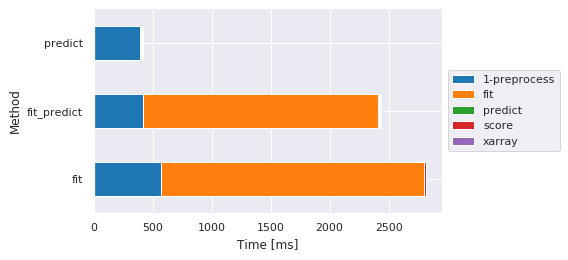

In [7]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method', style='darkgrid') # Default group/split
df

### Preprocessing main steps by method

Sub-sub-method,1-mask,2-feature_salinity,2-feature_temperature,3-homogeniser,4-xarray
Method,,,,,
fit,22.429943,118.067026,140.964270,2.250910,1.566172
fit_predict,19.100904,91.344118,90.978861,3.854275,1.348734
predict,23.853064,81.003904,88.092804,1.327991,1.497030


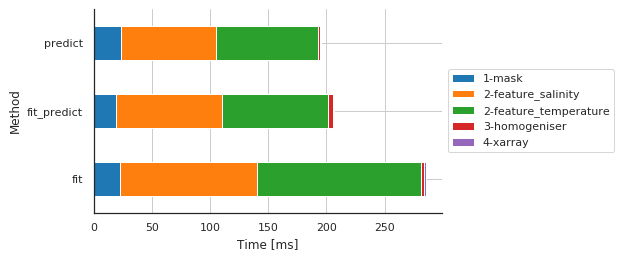

In [8]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Preprocessing details by method

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Method,,,,,,
fit,66.307068,2.079248,19.708157,10.671616,24.419069,6.174803
fit_predict,68.403482,2.030134,0.002861,11.577606,0.002861,9.014130
predict,63.980103,1.899958,0.001669,11.173010,0.003099,7.338047


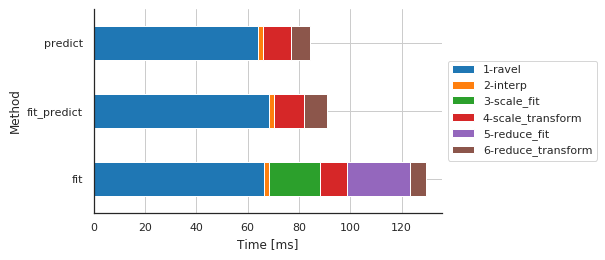

In [9]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Preprocessing details by features

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Sub-sub-method,,,,,,
2-feature_salinity,0.094785,0.002882,0.008617,0.017032,0.010785,0.010904
2-feature_temperature,0.103906,0.003127,0.011096,0.016391,0.013640,0.011623


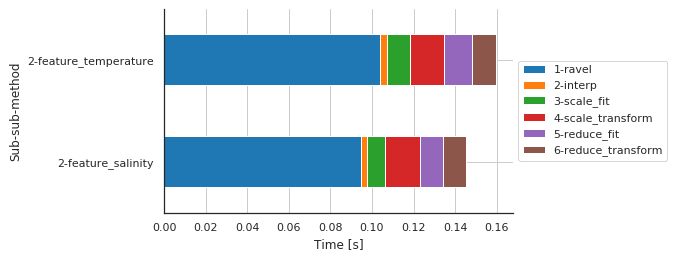

In [10]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method', unit='s')
df